In [8]:
import os, sys
#pathname = os.path.dirname(sys.argv[0])
#full_pathname = os.path.abspath(pathname)
#split_pathname = full_pathname.split(sep="mvesc")
#base_pathname = os.path.join(split_pathname[0], "mvesc")
#parentdir = os.path.join(base_pathname, "ETL")
#sys.path.insert(0,parentdir)
parentdir = os.path.abspath('/home/xcheng/mvesc/ETL')
sys.path.insert(0,parentdir)
from mvesc_utility_functions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image

%load_ext autotime
%matplotlib inline

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.56 ms


In [6]:
def barplot_feature_importance(table, schema='feature_scores', topN=10, save=True, savedir='./', figname=None,
                            name_column='feature', value_column='importance', 
                            xlabel='', ylabel='', title='', fontsize=16, figsize=(12, 8),
                            style='ggplot', kind='barh', dpi=500):
    """
    Bar Plot of any table in mvesc postgres
    Designed for feature importance: only need to specificy table name
    Other tables: specify table, schema, name_column, value_column
    Example:
    1. RF/ET feature importance table: barplot_feature_importance('table')
    2. Other tables: barplot_feature_importance('table', schema='schema', name_column='label', value_column='')
    
    :param str table: table name in postgres
    :param str schema: schema name
    :param int topN: number of top features to plot
    :param bool save: whether to save the fig
    :param str savedir: directory to save the fig
    :param str figname: figure name
    :param str name_column: column name of the label
    :param str value_column: column name of the values
    :param str xlabel, ylabel, title:
    :param int fontsize: fontsize for labels and titles
    :param tuple int figsize: figure size
    :param str style: plot style, 'ggplot', 'fivethirtyeight', etc
    :param str kind: bar plot kind, `bar`, `barh`
    :param int dpi: resolution, the larger the better
    :return str fn: figure name; if save==False, return None  
    """
    plt.style.use(style)
    with postgres_pgconnection_generator() as conn:
        feature_importances = read_table_to_df(conn, table, schema=schema)

    df = feature_importances[[value_column]]
    df.index = feature_importances[name_column]
    df = df.sort_values(by=[value_column], ascending=False)
    df = df.iloc[:topN, :]
    ax = df.iloc[::-1,:].plot(kind=kind, title=title, figsize=figsize, fontsize=fontsize, legend=False)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.tight_layout()
    if save==True:
        if figname==None:
            fn = os.path.join(savedir, 'feature_importance_'+table+'.png')
        else:
            fn = str(figname)
        plt.savefig(fn, dpi=dpi)
        return(fn)
    else:
        return(None)

time: 17.9 ms


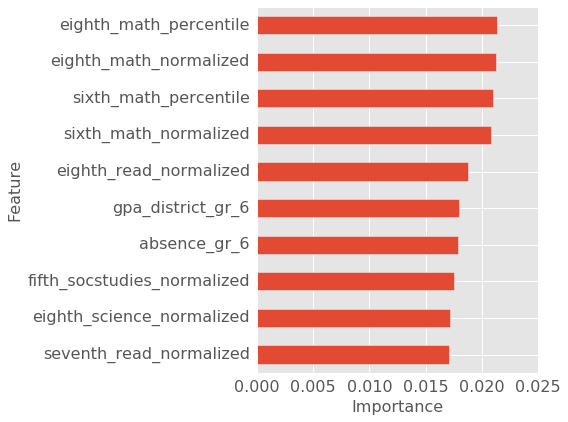

time: 444 ms


In [33]:
def barplot_df(dfbar, figname=None, save=False, savedir='./', 
               name_column='feature', value_column='importance', 
               xlabel='Importance', ylabel='Feature', title='', fontsize=16, figsize=(8, 6),
               style='ggplot', kind='barh', dpi=500):
    """
    Bar Plot of a data frame: the reason to have this is to save time to make better plots
    
    :param pd.dataframe df: data frame has at least 1 column of labels and 1 column of numeric values
    :param str figname: figure name; None means default name 
    :param bool save: whether to save the fig
    :param str savedir: directory to save the fig
    :param str name_column: column name of the label
    :param str value_column: column name of the values
    :param str xlabel, ylabel, title:
    :param int fontsize: fontsize for labels and titles
    :param tuple int figsize: figure size
    :param str style: plot style, 'ggplot', 'fivethirtyeight', etc
    :param str kind: bar plot kind, `bar`, `barh`
    :param int dpi: resolution, the larger the better
    :return str fn: figure name; if save==False, return None  
    """
    plt.style.use(style)
    df = dfbar[[value_column]]
    df.index = dfbar[name_column]
    df = df.sort_values(by=[value_column], ascending=False)
    ax = df.iloc[::-1,:].plot(kind=kind, title=title, figsize=figsize, fontsize=fontsize, legend=False)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.tight_layout()
    if save==True:
        if figname==None:
            fn = os.path.join(savedir, 'feature_importance.png')
        else:
            fn = str(figname)
        plt.savefig(fn, dpi=dpi)
        return(fn)
    else:
        return(None)

def read_model_topN_feature_importance(filename, topN=10, schema='model', table='feature_scores'):
    """
    Read top N feature importance from features scores table
    :param str filename: filename in the filename column
    :param int topN: top N features to read
    :param str schema: schema name
    :param str table: table name
    :return df
    :rtype pd.DataFrame
    """
    with postgres_pgconnection_generator() as conn:
        conn.autocommit =True
        sqlcmd="""
        select * from {s}.{t} 
        where filename like '%{f}%'
        order by importance desc
        limit {topN};
        """.format(s=schema, t=table, f=filename, topN=topN)
        df = pd.read_sql_query(sqlcmd, conn)
    return df

def barplot_feature_importance(filename, topN=10, schema='model', table='feature_scores',
                               figname=None, save=False, savedir='./', 
                               name_column='feature', value_column='importance', 
                               xlabel='Importance', ylabel='Feature', title='', 
                               fontsize=16, figsize=(8, 6),
                               style='ggplot', kind='barh', dpi=500):
    """
    Barplot feature importance for a specific filename in table `model.feature_scores`
    
    :param str filename: filename in the filename column
    :param int topN: top N features to read
    :param str schema: schema name
    :param str table: table name
    :param str figname: figure name; None means default name 
    :param bool save: whether to save the fig
    :param str savedir: directory to save the fig
    :param str name_column: column name of the label
    :param str value_column: column name of the values
    :param str xlabel, ylabel, title:
    :param int fontsize: fontsize for labels and titles
    :param tuple int figsize: figure size
    :param str style: plot style, 'ggplot', 'fivethirtyeight', etc
    :param str kind: bar plot kind, `bar`, `barh`
    :param int dpi: resolution, the larger the better
    :return str saved_figname: if save=True, return figure name; if save==False, return None 
    :rtype str
    """
    df = read_model_topN_feature_importance(filename, topN=topN, schema=schema, table=table)
    saved_figname = barplot_df(df, figname=figname, save=save, savedir=savedir, 
               name_column=name_column, value_column=value_column, 
               xlabel=xlabel, ylabel=ylabel, title=title, 
               fontsize=fontsize, figsize=figsize,
               style=style, kind=kind, dpi=dpi)
    return(saved_figname)

barplot_feature_importance(tables[1])

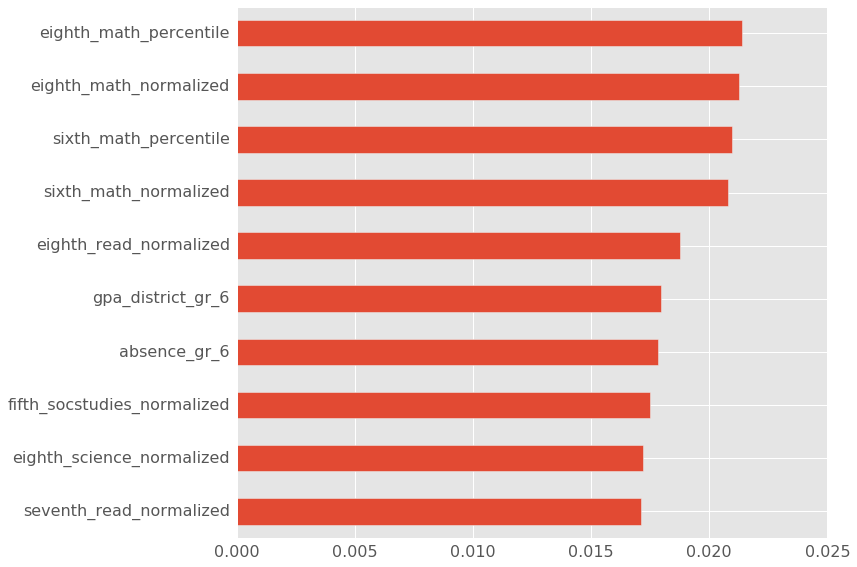

time: 491 ms


In [7]:
tables = ['08_09_2016_grade_6_param_set_0_RF_ht_8585',
'08_09_2016_grade_7_param_set_7_RF_ht_10497',
'08_09_2016_grade_8_param_set_13_RF_ht_13254',
'08_09_2016_grade_9_param_set_0_RF_ht_8645',
'08_09_2016_grade_10_param_set_0_RF_ht_8680']
tab = tables[1]
barplot_feature_importance(tab, save=False)
#for tab in tables:
#    barplot_feature_importance(tab, save=True, savedir='./figs/')

In [147]:
tables = ['08_09_2016_grade_6_param_set_0_RF_ht_8585',
'08_09_2016_grade_7_param_set_7_RF_ht_10497',
'08_09_2016_grade_8_param_set_13_RF_ht_13254',
'08_09_2016_grade_9_param_set_0_RF_ht_8645',
'08_09_2016_grade_10_param_set_0_RF_ht_8680']
top10_feautres = {}
topN = 10
with postgres_pgconnection_generator() as conn:
    for table in tables:
        df = read_table_to_df(conn, table, schema='feature_scores', nrows=-1)
        #df = df.sort_values(by=['importance'], ascending=False)
        #top10_feautres[table] = list(df.feature[:topN])

time: 72.8 ms


In [19]:
# function to return top N features from `model.feature_scores` table 
filename = '08_09_2016_grade_9_param_set_0_RF_ht_8645'
schema, table = 'model', 'feature_scores'
topN = 10
with postgres_pgconnection_generator() as conn:
    conn.autocommit =True
    with conn.cursor() as cursor:
        sqlcmd="""
        select * from {s}.{t} 
        where filename like '%{f}%'
        order by importance desc
        limit {topN};
        """.format(s=schema, t=table, f=filename, topN=topN)
        df = pd.read_sql_query(sqlcmd, conn)


time: 155 ms


,index,feature,importance,filename
0,0,gpa_gr_8,0.043742,08_09_2016_grade_9_param_set_0_RF_ht_8645
1,1,gpa_district_gr_8,0.043331,08_09_2016_grade_9_param_set_0_RF_ht_8645
2,2,absence_gr_8,0.033965,08_09_2016_grade_9_param_set_0_RF_ht_8645
3,3,eighth_math_percentile,0.030746,08_09_2016_grade_9_param_set_0_RF_ht_8645
4,4,stem_gpa_gr_8,0.029547,08_09_2016_grade_9_param_set_0_RF_ht_8645
5,5,eighth_math_normalized,0.029338,08_09_2016_grade_9_param_set_0_RF_ht_8645
6,6,humanities_gpa_gr_8,0.027986,08_09_2016_grade_9_param_set_0_RF_ht_8645
7,7,eighth_science_normalized,0.022717,08_09_2016_grade_9_param_set_0_RF_ht_8645
8,8,seventh_read_normalized,0.022167,08_09_2016_grade_9_param_set_0_RF_ht_8645
9,9,eighth_read_normalized,0.021853,08_09_2016_grade_9_param_set_0_RF_ht_8645


time: 10.5 ms
